In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

In [73]:
from michigan.fusion import Fusion
from michigan.dataprep import Data
import matplotlib.pyplot as plt
from nansat import Nansat, Domain
from michigan.michigan import MichiganProcessing
from michigan.plotbox import show_it
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

ImportError: No module named plotting

In [12]:
def get_bottom(bathymetry_path=Fusion.BATHYMETRY_PATH):
    bathymetry = Nansat(bathymetry_path)
    bathymetry.reproject(Data.sbd_dom)
    # preparing of bottom field
    h = bathymetry[1]
    # all points there h >= 0 will marked as np.nan
    h = np.where(h >= 0, np.nan, np.float32(h) * -1)
    return h

def get_land_mask(bathymetry_path=Fusion.BATHYMETRY_PATH):
    h = self.get_bottom(bathymetry_path=bathymetry_path)
    # the mask of land
    land_mask = np.where(np.isfinite(h), np.nan, np.array(1))
    return land_mask

def get_h_mask(h_max, h_min=None, bathymetry_path=Fusion.BATHYMETRY_PATH, mask_val=np.nan):
    h_mask = get_bottom(bathymetry_path=bathymetry_path)
    h_mask[h_mask > h_max] = mask_val

    if h_min is not None:
        h_mask[h_mask < h_min] = mask_val

    return h_mask


In [15]:
def bottom_classification(img, n_clusters, wavelengths_set='1x1km_bands', h_max=30, h_min=None):
    # We have to add one more class in classification for a land
    # TODO: Add capability to get data set by bottom depth
    k_train_arr = []
    # all pixels shallower then <h_mask> value should be masked
    mask = get_h_mask(h_max=h_max, h_min=h_min)
    
    for band in Data.wavelengths['modis'][wavelengths_set]:
        print 'Rrs_%s' % band
        arr = img['Rrs_%s' % band]
        # all 999 pixels will combined in one class
        arr[np.isnan(arr) == True] = 999
        arr[np.isnan(mask) == True] = 999
        k_train_arr.append(arr.ravel())

    k_train_arr = np.array(k_train_arr).T

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(k_train_arr)
    arr = kmeans.labels_
    arr = arr.reshape(Data.sbd_dom.shape())
    return arr


In [91]:
data_path = '/data/fused_data/20160705_20iter_neg_on_hires.nc'
data = Nansat(data_path)
class_number = 6

bottoms = np.arange(30, 0)
c = []


In [92]:
for a in range(0, len(bottoms) - 1):
    print('from %s m to %s m' % (bottoms[i], bottoms[i + 1]))
    c.apprend(bottom_classification(data, class_number, h_max=bottoms[i], h_min=bottoms[i + 1]))

In [78]:
wavelengths = Data.wavelengths['modis']['1x1km_bands']
data_info = pd.DataFrame({'wavelengths': wavelengths})
for cl in range(class_number):
    print('class: %s' % cl)
    class_arr = []
    for band in wavelengths:
        arr = data['Rrs_%s' % band]
        # all 999 pixels will combined in one class
        arr[c == cl] = np.nan
        class_arr.append(arr.ravel())
    
    class_arr = np.array(class_arr).T
    data_info['Rrs, class: %s' % cl] = pd.Series(np.nanmean(class_arr, axis=0), index=data_info.index)


class: 0
class: 1
class: 2
class: 3
class: 4
class: 5


In [79]:
data_info

,wavelengths,"Rrs, class: 0","Rrs, class: 1","Rrs, class: 2","Rrs, class: 3","Rrs, class: 4","Rrs, class: 5"
0,412,0.000832,0.001554,0.001556,0.001552,0.001552,0.001557
1,443,0.002597,0.002979,0.002982,0.002978,0.002977,0.002978
2,488,0.004388,0.003896,0.003895,0.003900,0.003899,0.003898
3,531,0.005858,0.003451,0.003438,0.003468,0.003465,0.003457
4,645,-0.000367,-0.000122,-0.000123,-0.000124,-0.000124,-0.000123
5,678,-0.000606,-0.000142,-0.000140,-0.000145,-0.000145,-0.000144


<IPython.core.display.Javascript object>


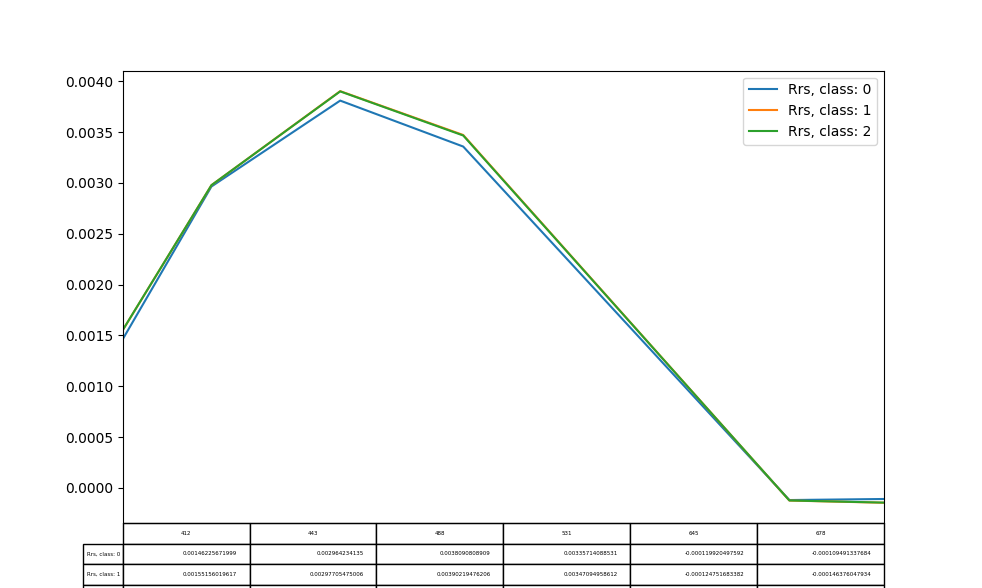

In [72]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data_info.plot(x='wavelengths', ax=ax, table=True)

In [81]:
np.arange(30, 0, -1)

array([30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14,
       13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])